In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sb
from numpy import median

# Import data

In [2]:
data = pd.read_csv("data/RealEstateAU_1000_Samples.csv")
data.head()

,index,TID,breadcrumb,category_name,property_type,building_size,land_size,preferred_size,open_date,listing_agency,...,state,zip_code,phone,latitude,longitude,product_depth,bedroom_count,bathroom_count,parking_count,RunDate
0,0,1350988,Buy>NT>DARWIN CITY,Real Estate & Property for sale in DARWIN CITY...,House,NaN,NaN,NaN,Added 2 hours ago,Professionals - DARWIN CITY,...,NT,800,08 8941 8289,NaN,NaN,premiere,2.0,1.0,1.0,2022-05-27 15:54:05
1,1,1350989,Buy>NT>DARWIN CITY,Real Estate & Property for sale in DARWIN CITY...,Apartment,171m²,NaN,171m²,Added 7 hours ago,Nick Mousellis Real Estate - Eview Group Member,...,NT,800,0411724000,NaN,NaN,premiere,3.0,2.0,2.0,2022-05-27 15:54:05
2,2,1350990,Buy>NT>DARWIN CITY,Real Estate & Property for sale in DARWIN CITY...,Unit,NaN,NaN,NaN,Added 22 hours ago,Habitat Real Estate - THE GARDENS,...,NT,800,08 8981 0080,NaN,NaN,premiere,2.0,1.0,1.0,2022-05-27 15:54:05
3,3,1350991,Buy>NT>DARWIN CITY,Real Estate & Property for sale in DARWIN CITY...,House,NaN,NaN,NaN,Added yesterday,Ray White - NIGHTCLIFF,...,NT,800,08 8982 2403,NaN,NaN,premiere,1.0,1.0,0.0,2022-05-27 15:54:05
4,4,1350992,Buy>NT>DARWIN CITY,Real Estate & Property for sale in DARWIN CITY...,Unit,201m²,NaN,201m²,Added yesterday,Carol Need Real Estate - Fannie Bay,...,NT,800,0418885966,NaN,NaN,premiere,3.0,2.0,2.0,2022-05-27 15:54:05


# Data Cleaning

In [3]:
data.isnull().sum()

index                 0
TID                   0
breadcrumb            0
category_name         0
property_type         0
building_size       720
land_size           467
preferred_size      391
open_date           698
listing_agency        0
price                 0
location_number       0
location_type         0
location_name         0
address              12
address_1            12
city                  0
state                 0
zip_code              0
phone                 0
latitude           1000
longitude          1000
product_depth         0
bedroom_count        33
bathroom_count       33
parking_count        33
RunDate               0
dtype: int64

index, TID, breadcrumb, cateogry_name, open_date, RunDate - these columns represent information about the listing or the dataset, not the house itself

listing_agency- while useful, the sheer number of categories and the time constraint make this difficult to properly clean; would be useful to see if certain agencies are correlated to housing premiums/discounts

location_number, location_type, location_name- these columns do not provide information on the housing itself

address, address_1, city, state, zip_code, phone - these columns involve largely information unique to the housing and listing/lister. 

latitude, longitude - these columns are solely filled with null values

preferred_size - not particularly useful; preferred size isn't a true statistic of the house


In [4]:
removeCol = ["index", "TID", "breadcrumb", "category_name", "open_date", 
             "preferred_size", "listing_agency",
             "location_number", "location_type", "location_name", "address",
            "address_1", "city", "state", "zip_code", "phone", "latitude",
            "longitude", "RunDate"]

In [5]:
data_c = data.drop(removeCol, axis = 1)
data_c.head()

,property_type,building_size,land_size,price,product_depth,bedroom_count,bathroom_count,parking_count
0,House,NaN,NaN,"$435,000",premiere,2.0,1.0,1.0
1,Apartment,171m²,NaN,"Offers Over $320,000",premiere,3.0,2.0,2.0
2,Unit,NaN,NaN,"$310,000",premiere,2.0,1.0,1.0
3,House,NaN,NaN,"$259,000",premiere,1.0,1.0,0.0
4,Unit,201m²,NaN,"$439,000",premiere,3.0,2.0,2.0


In [6]:
# remove acreage, block of units, other, villa, studio, lifestyle, and warehouse- represent minimal portion of the dataset
# and are in such small numbers to be inpractical for modeling

# remove residential land - there are no amenities included, difficult to estimate missing values

data_c["property_type"].value_counts()

House                   441
Unit                    230
Apartment               212
Townhouse                38
Residential Land         33
Duplex/Semi-detached     19
Acreage                   9
Block Of Units            6
Other                     4
Villa                     4
Studio                    2
Warehouse                 1
Lifestyle                 1
Name: property_type, dtype: int64

In [7]:
# remove midtier- very few housing in this category, better to remove and prevent issues from occuring
data_c["product_depth"].value_counts()

premiere    659
feature     172
standard    162
midtier       7
Name: product_depth, dtype: int64

In [8]:
removePropType = ["Residential Land", "Acreage", "Block Of Units", "Other", 
                  "Villa", "Studio", "Lifestyle", "Warehouse"]

data_c2 = data_c[~data_c["property_type"].isin(removePropType)]
data_c2 = data_c2[data_c2["product_depth"] != "midtier"]

data_c2

,property_type,building_size,land_size,price,product_depth,bedroom_count,bathroom_count,parking_count
0,House,NaN,NaN,"$435,000",premiere,2.0,1.0,1.0
1,Apartment,171m²,NaN,"Offers Over $320,000",premiere,3.0,2.0,2.0
2,Unit,NaN,NaN,"$310,000",premiere,2.0,1.0,1.0
3,House,NaN,NaN,"$259,000",premiere,1.0,1.0,0.0
4,Unit,201m²,NaN,"$439,000",premiere,3.0,2.0,2.0
...,...,...,...,...,...,...,...,...
995,House,NaN,9.17ha,2 Residence,feature,4.0,3.0,6.0
996,House,203m²,600m²,"$601,000",standard,4.0,2.0,2.0
997,House,209.6m²,800m²,"$655,000",standard,4.0,2.0,2.0
998,House,180m²,450m²,"$675,000",standard,4.0,2.0,3.0


## First pass of size predictors

In [9]:
def removeMeters(string):
    if(pd.isna(string)): 
        return
    else: 
        return string.replace("m²","")

In [10]:
# some units are hectare, others meters squared- corrects numbers to be in meteres squared
def correctSize(string):
    if(pd.isna(string)): 
        return
    else: 
        if "ha" in string:
            return float(re.sub("[a-zA-Z,]", "", string))*10000
        else:
            string2 = string.replace("m²","")
            return float(re.sub("[a-zA-Z,]", "", string2))

In [11]:
sizePredictors = ["building_size","land_size"]

In [12]:
data_c3 = data_c2.copy()
data_c3["building_size"] = data_c3["building_size"].apply(correctSize)
data_c3["land_size"] = data_c3["land_size"].apply(correctSize)

In [13]:
data_c3

,property_type,building_size,land_size,price,product_depth,bedroom_count,bathroom_count,parking_count
0,House,NaN,NaN,"$435,000",premiere,2.0,1.0,1.0
1,Apartment,171.0,NaN,"Offers Over $320,000",premiere,3.0,2.0,2.0
2,Unit,NaN,NaN,"$310,000",premiere,2.0,1.0,1.0
3,House,NaN,NaN,"$259,000",premiere,1.0,1.0,0.0
4,Unit,201.0,NaN,"$439,000",premiere,3.0,2.0,2.0
...,...,...,...,...,...,...,...,...
995,House,NaN,91700.0,2 Residence,feature,4.0,3.0,6.0
996,House,203.0,600.0,"$601,000",standard,4.0,2.0,2.0
997,House,209.6,800.0,"$655,000",standard,4.0,2.0,2.0
998,House,180.0,450.0,"$675,000",standard,4.0,2.0,3.0


## Price Cleaning

In [14]:
def isPrice(string):
    if "$" in string: 
        return True
    else: 
        return False

In [15]:
def removeAlphabetic(string):
    if(pd.isna(string)): 
        return np.nan
    string2 = re.sub("[a-zA-Z,$]", "", string)
    try:
        return float(string2.replace(" ",""))
    except:
        return np.nan

In [16]:
# data imputation version for price - may not do: worsens model performance
# additionally, many of these "prices" are negotiable, under contract, etc: 
    #more or less unknowable, and most likely higher than the median price

data_c3.loc[~data_c3["price"].apply(isPrice), "price"] = np.nan
data_c3
data_c4 = data_c3.copy()

In [17]:
# remove all rows that do not have a numerical "price"
# these "prices" are often "UNDER CONTRACT", "Negotiable", "Contact Agent"
#data_c4 = data_c3.loc[data_c3["price"].apply(isPrice)]

In [18]:
data_c4["price"] = data_c4["price"].apply(removeAlphabetic).copy()

In [19]:
data_c4

,property_type,building_size,land_size,price,product_depth,bedroom_count,bathroom_count,parking_count
0,House,NaN,NaN,435000.0,premiere,2.0,1.0,1.0
1,Apartment,171.0,NaN,320000.0,premiere,3.0,2.0,2.0
2,Unit,NaN,NaN,310000.0,premiere,2.0,1.0,1.0
3,House,NaN,NaN,259000.0,premiere,1.0,1.0,0.0
4,Unit,201.0,NaN,439000.0,premiere,3.0,2.0,2.0
...,...,...,...,...,...,...,...,...
995,House,NaN,91700.0,NaN,feature,4.0,3.0,6.0
996,House,203.0,600.0,601000.0,standard,4.0,2.0,2.0
997,House,209.6,800.0,655000.0,standard,4.0,2.0,2.0
998,House,180.0,450.0,675000.0,standard,4.0,2.0,3.0


In [20]:
data_c4.isnull().sum()/len(data_c4)

property_type     0.000000
building_size     0.711991
land_size         0.482869
price             0.268737
product_depth     0.000000
bedroom_count     0.000000
bathroom_count    0.000000
parking_count     0.000000
dtype: float64

## Data imputation

<AxesSubplot:>

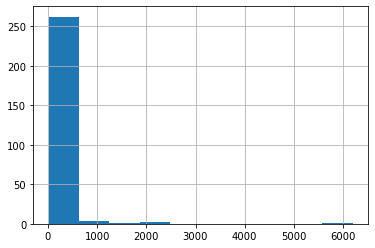

In [21]:
# distribution is unbalanced, use median to impute values
data_c4["building_size"].hist()

<AxesSubplot:>

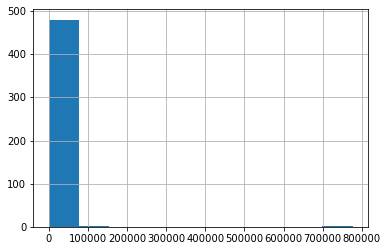

In [22]:
# distribution is unbalanced, use median to impute values
data_c4["land_size"].hist()

<AxesSubplot:>

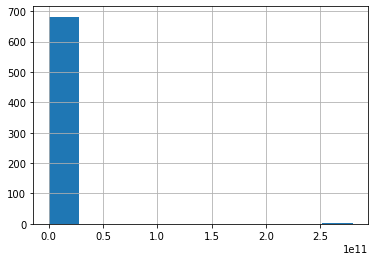

In [23]:
# distribution is unbalanced, use median to impute values
data_c4["price"].hist()

In [24]:
median_df = data_c4.groupby("property_type").median()
median_df

,building_size,land_size,price,bedroom_count,bathroom_count,parking_count
property_type,,,,,,
Apartment,135.0,178.0,450000.0,2.0,2.0,2.0
Duplex/Semi-detached,354.0,352.0,450000.0,3.0,2.0,2.0
House,210.0,804.0,555000.0,4.0,2.0,2.0
Townhouse,99.5,294.5,645000.0,3.0,2.0,2.0
Unit,107.0,153.0,377500.0,2.0,1.0,2.0


In [25]:
data_c5 = data_c4.groupby("property_type").transform(lambda x: x.fillna(x.median()))
data_c5["property_type"] = data_c4["property_type"]
data_c5["product_depth"] = data_c4["product_depth"]
data_c5.head()

,building_size,land_size,price,bedroom_count,bathroom_count,parking_count,property_type,product_depth
0,210.0,804.0,435000.0,2.0,1.0,1.0,House,premiere
1,171.0,178.0,320000.0,3.0,2.0,2.0,Apartment,premiere
2,107.0,153.0,310000.0,2.0,1.0,1.0,Unit,premiere
3,210.0,804.0,259000.0,1.0,1.0,0.0,House,premiere
4,201.0,153.0,439000.0,3.0,2.0,2.0,Unit,premiere


In [26]:
data_c5.isnull().sum()/len(data_c4)

building_size     0.0
land_size         0.0
price             0.0
bedroom_count     0.0
bathroom_count    0.0
parking_count     0.0
property_type     0.0
product_depth     0.0
dtype: float64

## Price Outlier Cleaning

In [27]:
def getQuantiles(column):
    quantiles = np.quantile(column, [0, 0.25, 0.5, 0.75, 1])
    q1 = quantiles[1]
    q3 = quantiles[3]
    return [q1, q3]

In [28]:
quantiles = getQuantiles(data_c5["price"])
iqr = quantiles[1]-quantiles[0]
data_c6 = data_c5.loc[(data_c5["price"] <= quantiles[1] + 1.5*iqr) & 
                      (data_c5["price"] >= 0) &
                     (data_c5["price"] >= quantiles[0] - 1.5*iqr)]
#data_c7 = data_c6.loc[data_c6["price"] >= priceQ[0] - 1.5*iqr]

<AxesSubplot:xlabel='price'>

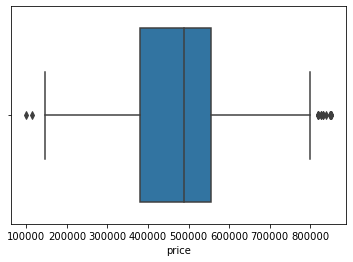

In [29]:
sb.boxplot(data = data_c6, x = "price")

In [30]:
quantiles = getQuantiles(data_c6["building_size"])
iqr = quantiles[1]-quantiles[0]
data_c7 = data_c6.loc[(data_c6["building_size"] <= quantiles[1] + 1.5*iqr) & 
                      (data_c6["building_size"] >= 0) &
                     (data_c6["building_size"] >= quantiles[0] - 1.5*iqr)]

<AxesSubplot:xlabel='building_size'>

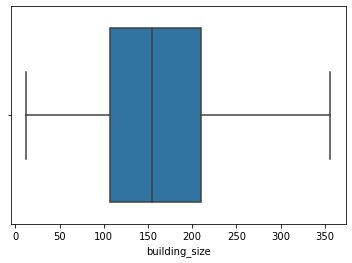

In [31]:
sb.boxplot(data = data_c7, x = "building_size")

In [32]:
quantiles = getQuantiles(data_c7["land_size"])
iqr = quantiles[1]-quantiles[0]
data_c8 = data_c7.loc[(data_c7["land_size"] <= quantiles[1] + 1.5*iqr) & 
                      (data_c7["land_size"] >= 0) &
                     (data_c7["land_size"] >= quantiles[0] - 1.5*iqr)]

<AxesSubplot:xlabel='land_size'>

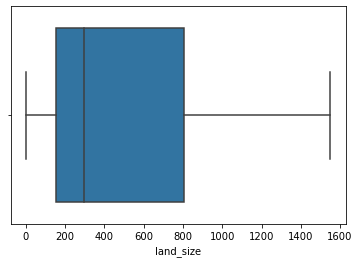

In [33]:
sb.boxplot(data = data_c8, x = "land_size")

In [34]:
data_clean = data_c8.copy()

# EDA

In [35]:
# 876 observations, 8 variables (7 predictors, 1 target)
data_clean.shape

(843, 8)

In [36]:
# view the statistics of the dataset
data_clean.describe()

,building_size,land_size,price,bedroom_count,bathroom_count,parking_count
count,843.000000,843.000000,843.000000,843.000000,843.000000,843.000000
mean,164.373796,435.195374,483623.665480,2.774614,1.690391,1.981020
std,61.302913,309.209014,136946.012692,1.093696,0.583006,1.183666
min,12.000000,1.000000,99950.000000,0.000000,1.000000,0.000000
25%,107.000000,154.000000,377500.000000,2.000000,1.000000,1.000000
50%,147.000000,294.500000,485000.000000,3.000000,2.000000,2.000000
75%,210.000000,804.000000,555000.000000,3.000000,2.000000,2.000000
max,356.000000,1550.000000,850000.000000,9.000000,4.000000,10.000000


In [37]:
summaryStats =  data_clean.describe()

In [38]:
iqr = summaryStats.loc["75%"] - summaryStats.loc["25%"]

In [39]:
summaryStats.loc["50%"]

building_size        147.0
land_size            294.5
price             485000.0
bedroom_count          3.0
bathroom_count         2.0
parking_count          2.0
Name: 50%, dtype: float64

In [40]:
iqr

building_size        103.0
land_size            650.0
price             177500.0
bedroom_count          1.0
bathroom_count         1.0
parking_count          1.0
dtype: float64

In [41]:
data_clean["property_type"].value_counts()

House                   375
Unit                    221
Apartment               192
Townhouse                36
Duplex/Semi-detached     19
Name: property_type, dtype: int64

In [42]:
data_clean["product_depth"].value_counts()

premiere    563
feature     154
standard    126
Name: product_depth, dtype: int64

In [43]:
pd.crosstab(data_clean["property_type"],data_clean["product_depth"], 
            margins = True)

product_depth,feature,premiere,standard,All
property_type,,,,
Apartment,58,100,34,192
Duplex/Semi-detached,2,12,5,19
House,49,282,44,375
Townhouse,3,29,4,36
Unit,42,140,39,221
All,154,563,126,843


In [44]:
filepath = "visualizations/"

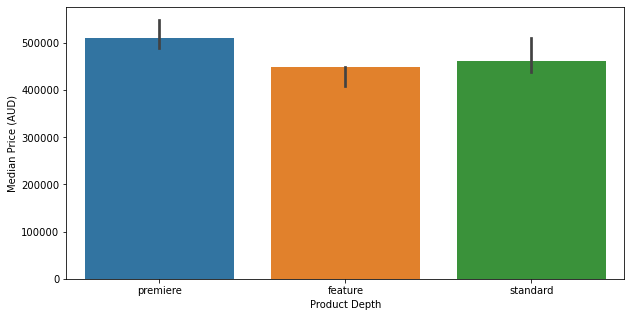

In [45]:
# product depth - somewhat similar median housing prices, but the median price of premier is highest
plt.figure(figsize = (10, 5))
sb.barplot(x = "product_depth",y = "price", data = data_clean, 
           estimator = median)
plt.xlabel("Product Depth")
plt.ylabel("Median Price (AUD)")
plt.savefig(filepath + 'productDepth_price.png')
plt.show()

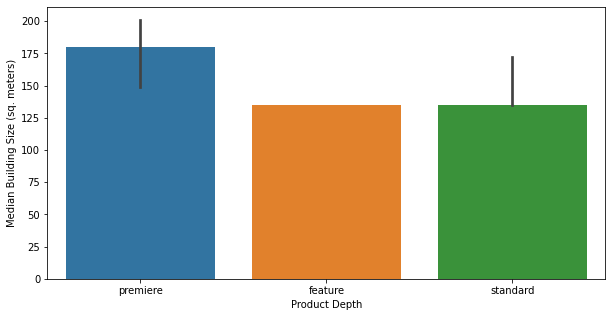

In [46]:
# product depth - premiere properties have the largest median building size
plt.figure(figsize = (10, 5))
sb.barplot(x = "product_depth",y = "building_size", data = data_clean, 
           estimator = median)
plt.xlabel("Product Depth")
plt.ylabel("Median Building Size (sq. meters)")
plt.savefig(filepath + 'productDepth_building.png')
plt.show()

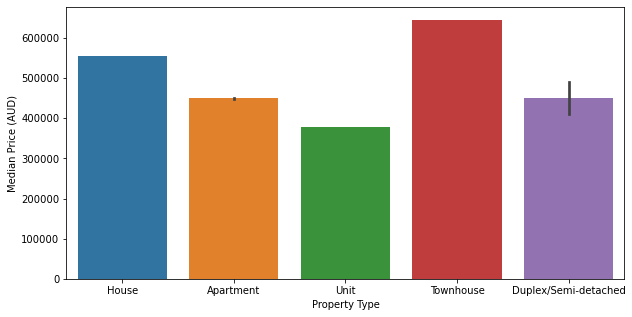

In [47]:
# property type - townhouses and houses have the highest median prices, units the lowest
plt.figure(figsize = (10, 5))
sb.barplot(x = "property_type",y = "price", data = data_clean, estimator = median)
plt.xlabel("Property Type")
plt.ylabel("Median Price (AUD)")
plt.savefig(filepath + 'propType_price.png')
plt.show()

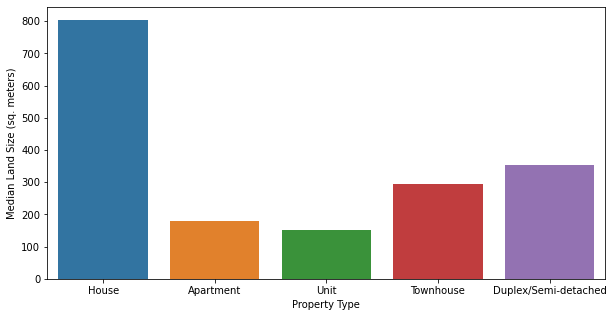

In [48]:
# property type - houses have the largest land size
plt.figure(figsize = (10, 5))
sb.barplot(x = "property_type",y = "land_size", data = data_clean, estimator = median)
plt.xlabel("Property Type")
plt.ylabel("Median Land Size (sq. meters)")
plt.savefig(filepath + 'propType_land.png')
plt.show()

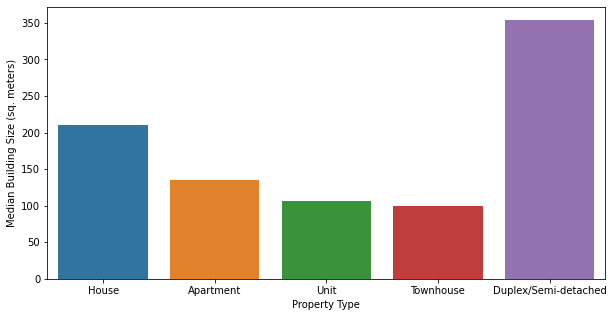

In [49]:
# property type - duplex get the biggest building sizes
plt.figure(figsize = (10, 5))
sb.barplot(x = "property_type",y = "building_size", data = data_clean, estimator = median)
plt.xlabel("Property Type")
plt.ylabel("Median Building Size (sq. meters)")
plt.savefig(filepath + 'propType_building.png')
plt.show()

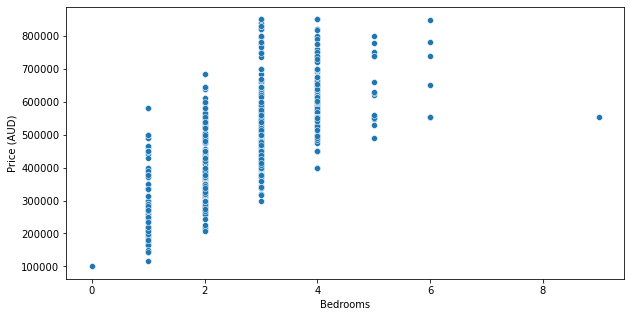

In [50]:
# general trend- more bedrooms increases housing price
plt.figure(figsize = (10, 5))
sb.scatterplot(x = "bedroom_count",y = "price", data = data_clean)
plt.xlabel("Bedrooms")
plt.ylabel("Price (AUD)")
plt.savefig(filepath + 'bedroom_price.png')
plt.show()

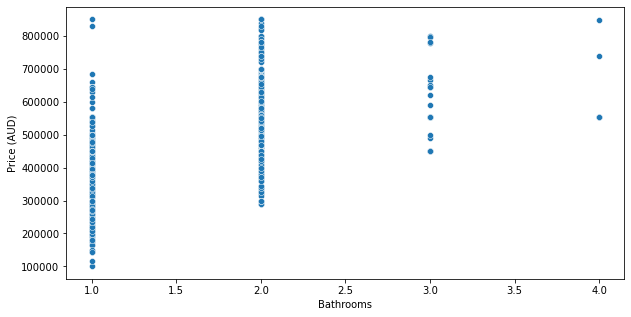

In [51]:
# general trend- more bathrooms increases housing price
plt.figure(figsize = (10, 5))
sb.scatterplot(x = "bathroom_count",y = "price", data = data_clean)
plt.xlabel("Bathrooms")
plt.ylabel("Price (AUD)")
plt.savefig(filepath + 'bathroom_price.png')
plt.show()

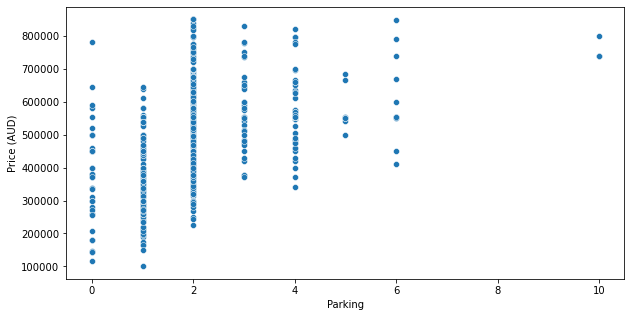

In [52]:
# general trend- more parking increases housing price
plt.figure(figsize = (10, 5))
sb.scatterplot(x = "parking_count",y = "price", data = data_clean)
plt.xlabel("Parking")
plt.ylabel("Price (AUD)")
plt.savefig(filepath + 'parking_price.png')
plt.show()

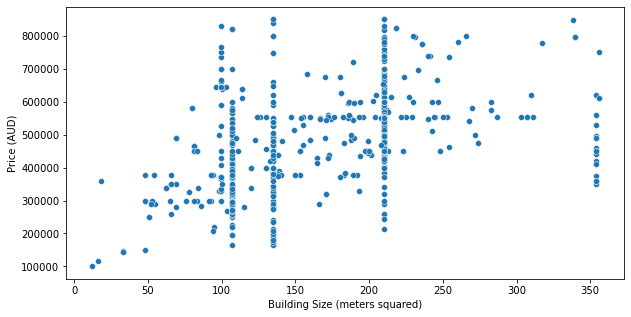

In [53]:
# general trend- more parking increases housing price
plt.figure(figsize = (10, 5))
sb.scatterplot(x = "building_size",y = "price", data = data_clean)
plt.xlabel("Building Size (meters squared)")
plt.ylabel("Price (AUD)")
plt.savefig(filepath + 'buildsize_price.png')
plt.show()

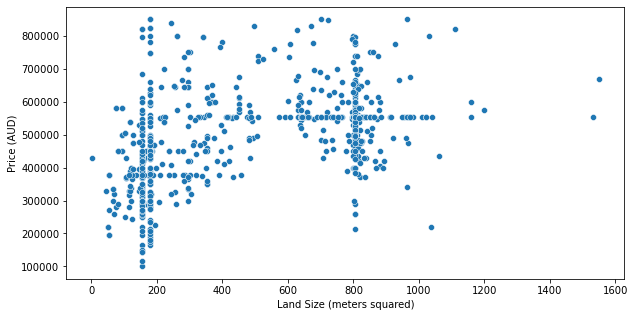

In [54]:
# general trend- more parking increases housing price
plt.figure(figsize = (10, 5))
sb.scatterplot(x = "land_size",y = "price", data = data_clean)
plt.xlabel("Land Size (meters squared)")
plt.ylabel("Price (AUD)")
plt.savefig(filepath + 'landsize_price.png')
plt.show()

In [55]:
#export data
filepath = "data/"
data_clean.to_csv(filepath+"data_clean.csv", index = False)